## Set up libraries

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [ ]:
from functools import partial
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

In [ ]:
import sys
sys.path.append("../..")

from adversarial_ntks import attacks, jsvc, kernel

## Kernel regression

Similar classifier setup to the SVM case, though we drop the intercept $b$ to simplify analysis.
(This should be fine since we can get the intercept back via the kernel).

So our classifier $f_\alpha: \mathcal{X} \to \mathbb{R}$ acts as

$$
f_{\alpha}(x) = \sum_{i = 1}^n \alpha_i \, k(x_i, x).
$$

Our loss for the regression case is just MSE, so we want to solve the problem

$$
\underset{\alpha \,\in \, \mathbb{R}^n}{\mathrm{argmin}} \quad
\frac{1}{n} \sum_{i = 1}^n (f_\alpha(x_i) - y_i)^2 + \lambda R(\alpha).
$$

where $R(\alpha)$ is a regularizer and $\lambda > 0$ controls its strength.

Under ridge regression, the objective of the minimization can equivalently be written as

$$
\mathcal{L}(\alpha)
= \frac{1}{n} \|K \alpha - Y\|_2 + \lambda R(\alpha),
$$

where $K \in \mathbb{R}^{n \times n}$ with $K_{ij} = k(x_i, x_j)$
and $Y \in \mathbb{R}^n$ with $Y_i = y_i$.

def binary_to_sign(ys: np.ndarray):
Two common forms of $R(\alpha)$ that are amenable to analysis are
$\|\alpha\|_2^2$ or
$\|\alpha\|_H^2 = \sum_{i = 1}^n \sum_{j = 1}^n \alpha_i \, \alpha_j \, k(x_i, x_j)$.
We study both below.

### Ridge regularization
This is the case where $R(\alpha) = \|\alpha\|_2^2$.

The first order condition for minimization of $\mathcal{L}(\cdot)$ is
$K (K\alpha - Y) + \lambda n \alpha = 0$.
Thus when $\lambda > 0$, there is a unique minimizer

$$
\alpha^* = (KK + \lambda n I_n)^{-1} K Y = (K + \lambda n K^+)^+ Y
$$

Why is this unique? Well $KK$ is positive semi-definite so when $\lambda >0$ the sum $KK + \lambda n I_n$ is positive definite and invertible.
  
In the limit as $\lambda \to 0$, we get $\alpha^* \to K^+ Y$, where $K^+$ is the [Moore–Penrose psuedo-inverse](https://en.wikipedia.org/w/index.php?title=Moore%E2%80%93Penrose_inverse&oldid=1015125066#Limit_relations) of $K$.

### RKHS regularization
This is the case where $R(\alpha) = \|\alpha\|_2^2$.

The first order condition for minimization of $\mathcal{L}(\cdot)$ is
$K(K\alpha - Y) + \lambda n K \alpha = 0$.
When $K$ is invertible, there is a unique minimizer

$$\alpha^* = (K + \lambda n I_n)^{-1} Y.$$

When $K$ is invertible, in the limit as $\lambda \to 0$ we get $\alpha^* = K^{-1}Y$.

When $K$ is not invertible, there may be multiple global minima.
The one with smallest norm is given by

$$
\alpha^*_{\mathrm{min}} = (KK + \lambda n K)^+ K Y = (K + \lambda n I_n)^+ K^+ K Y.
$$

One instance where $K$ is always invertible (as long as datapoints are unique) is the RBF kernel,
which is [strictly positive definite](https://math.stackexchange.com/q/130554/85418).

In [ ]:
class JKernelRegressor:
    """Jax-based kernel regressor"""
    
    def __init__(
        self,
        kernel: str,
        regularizer: str,
        lam: float,
        gamma: Optional[float] = None,
        degree: Optional[int] = None,
    ):
        """Small positive lam may cause numerical issues. Use lam = 0 instead."""
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        
        self.regularizer = regularizer
        self.lam = lam
        
        assert self.lam >= 0
    
    def get_kernel_mat(self, X1: jnp.ndarray, X2: jnp.ndarray) -> jnp.ndarray:
        """
        X1: shape (n1, d)
        X1: shape (n2, d)
        return: shape (n1, n2)
        """
        
        if self.kernel == "linear":
            return kernel.linear(SV, X)
        elif self.kernel == "poly":
            return kernel.poly(X1, X2, gamma=self.gamma, coef0=1, degree=self.degree)
        elif self.kernel == "rbf":
            return kernel.rbf(X1, X2, gamma=self.gamma)
        
        raise NotImplementedError
    
    @partial(jax.jit, static_argnums=(0,))
    def _fit_alpha(self, K, ys):
        """For JITing"""
        n = K.shape[0]
        if self.regularizer == "ridge":
            # return jnp.linalg.pinv(K + self.lam * n * self.linalg.pinv(K)) @ ys
            if self.lam > 0:
                return jnp.linalg.inv(K @ K + self.lam * n * jnp.eye(n)) @ K @ ys
            return jnp.linalg.pinv(K) @ ys
                
        elif self.regularizer == "rkhs":
            return jnp.linalg.pinv(K @ K + self.lam * n * K) @ K @ ys
       
        raise NotImplementedError
    
    def fit(self, xs: jnp.ndarray, ys: jnp.ndarray):
        """
        xs: shape (n, d)
        ys: shape (n,)
        """
        self.xs = xs.copy()
        self.ys = ys.copy()
        
        self.K = self.get_kernel_mat(xs, xs)        
        self.alpha = self._fit_alpha(K=self.K, ys=self.ys)
    
    def predict(self, xs: jnp.ndarray) -> jnp.ndarray:
        """
        xs: shape (n, d)
        """
        return self.get_kernel_mat(xs, self.xs) @ self.alpha
    
    def predict_thresh(self, xs: jnp.ndarray, thresh: float = 0.5) -> jnp.ndarray:
        """
        xs: shape (n, d)
        """
        return (self.predict(xs) > thresh).astype(jnp.int64)
    
def _kreg_predict_sum(kreg: JKernelRegressor, xs: jnp.ndarray):
    return kreg.predict(xs).sum()

grad_kreg_predict_sum = jax.jit(
    jax.grad(_kreg_predict_sum, 1),
    static_argnums=0,
)

In [2]:
def eval_kreg(
    reg: JKernelRegressor,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    verbose: bool = True,
    label: str = "",
):
    accs_train = accs_by_cls(preds=reg.predict_thresh(xs_train), ys=ys_train)
    accs_test = accs_by_cls(preds=reg.predict_thresh(xs_test), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train={fmt_accs(accs_train)}; accs_test={fmt_accs(accs_test)}")
    
    xs_train_arad = radial_attack(xs=xs_train, ys=ys_train, attack_norm=2, attack_eps=attack_eps)
    xs_test_arad = radial_attack(xs=xs_test, ys=ys_test, attack_norm=2, attack_eps=attack_eps)
    accs_train_arad = accs_by_cls(preds=reg.predict_thresh(xs_train_arad), ys=ys_train)
    accs_test_arad = accs_by_cls(preds=reg.predict_thresh(xs_test_arad), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train_arad={fmt_accs(accs_train_arad)}; accs_test_arad={fmt_accs(accs_test_arad)}")
    
    xs_train_pgd = attacks.pgd(
        X=jnp.array(xs_train), Y=jnp.array(ys_train),
        grad_func=lambda X: grad_kreg_predict_sum(reg, X),
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=False,
    )
    xs_test_pgd = attacks.pgd(
        X=jnp.array(xs_test), Y=jnp.array(ys_test),
        grad_func=lambda X: grad_kreg_predict_sum(reg, X),
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=False,
    )
    accs_train_pgd = accs_by_cls(preds=reg.predict_thresh(xs_train_pgd), ys=ys_train)
    accs_test_pgd = accs_by_cls(preds=reg.predict_thresh(xs_test_pgd), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train_pgd={fmt_accs(accs_train_pgd)}; accs_test_pgd={fmt_accs(accs_test_pgd)}")

    return dict(
        accs_train=accs_train,
        accs_test=accs_test,
        attack_eps=attack_eps,
        accs_train_arad=accs_train_arad,
        accs_test_arad=accs_test_arad,
        accs_train_pgd=accs_train_pgd,
        accs_test_pgd=accs_test_pgd,
        xs_train_pgd=xs_train_pgd,
        xs_test_pgd=xs_test_pgd,
    )

NameError: name 'JKernelRegressor' is not defined

## RBF regression

#### Ridge regularization

In [ ]:
%%time
attack_eps = 0.1

RESULTS["reg-rbf"] = []
for lam in [0, 1e-9, 1e-6, 1e-3, 1]:
    reg = JKernelRegressor(
        kernel="rbf",
        regularizer="ridge",
        lam=lam,
        gamma=1
    )
    reg.fit(xs_train, ys_train)
    
    res_dict = dict(reg=reg)
    res_dict.update(
        eval_kreg(
            reg=reg,
            label=f"lam={lam}",
            attack_eps=0.1,
            pgd_step_size=0.1/10,
            pgd_num_steps=20,
        )
    )

    RESULTS["reg-rbf"].append(res_dict)

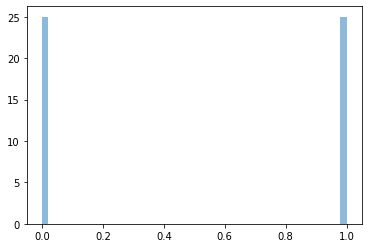

In [23]:
plt.hist(RESULTS["reg-rbf"][0]["reg"].predict(xs_train), density=True, bins=50, alpha=0.5);

In [ ]:
plt.hist(RESULTS["reg-rbf"][0]["reg"].predict(xs_test), density=True, bins=50, alpha=0.5);

#### RKHS regularization

In [ ]:
%%time
attack_eps = 0.1

RESULTS["reg-rbf"] = []
for lam in [0, 1e-9, 1e-6, 1e-3, 1, 1e3]:
    reg = JKernelRegressor(
        kernel="rbf",
        regularizer="rkhs",
        lam=lam,
        gamma=1
    )
    reg.fit(xs_train, ys_train)
    
    res_dict = dict(reg=reg)
    res_dict.update(
        eval_kreg(
            reg=reg,
            label=f"lam={lam}",
            attack_eps=0.1,
            pgd_step_size=0.1/10,
            pgd_num_steps=20,
        )
    )

    RESULTS["reg-rbf"].append(res_dict)

## Poly regression

#### Ridge regularization

#### RKHS regularization